```{index} single: Pyomo; block
```
```{index} bilinear constraints
```
```{index} McCormick envelopes
```
```{index} single: Pyomo; block
```
```{index} single: Pyomo; block
```
```{index} single: solver; cbc
```
```{index} single: solver; couenne
```
# Milk pooling and blending

This notebook provides an overview of bilinear pooling and blending issues, using a small milk blending operation as an example. The notebook demonstrates the essential non-convex nature of these problems and explains the two fundamental formulations, known as P- and Q-parameterizations.

In [3]:
import sys
import os

if 'google.colab' in sys.modules:
    !pip install idaes-pse --pre >/dev/null 2>/dev/null
    !idaes get-extensions --to ./bin 
    os.environ['PATH'] += ':bin'

## Bibliographic Notes

The pooling and blending is a large scale, high value, fundamental problem of logistics for the process and refining industries. The prototypical examples are the pooling and blending crude oils to meet the feed stock constraints of refineries, and for the pooling of refinery products for pipeline delivery to distribution terminals. Un

Haverly (1978) is a commonly cited small benchmark problem for the pooling and blending of sulfurous fuels. 

> Haverly, C. A. (1978). Studies of the behavior of recursion for the pooling problem. Acm sigmap bulletin, (25), 19-28. https://dl.acm.org/doi/pdf/10.1145/1111237.1111238

There is an extensive literature on pooling and blending. The following encyclopedia entry explains the history of the pooling problem, how it leads to multiple local minima and other pathological behaviors, and approaches to finding practical solutions.

> Visweswaran, V. (2009). MINLP: Applications in Blending and Pooling Problems. https://link.springer.com/referenceworkentry/10.1007/978-0-387-74759-0_375

Recent research overviews include


> Misener, R., & Floudas, C. A. (2009). Advances for the pooling problem: Modeling, global optimization, and computational studies. Applied and Computational Mathematics, 8(1), 3-22. https://www.researchgate.net/profile/Ruth-Misener/publication/242290955_Advances_for_the_pooling_problem_Modeling_global_optimization_and_computational_studies_Survey/links/0046352e7d1dfeb40f000000/Advances-for-the-pooling-problem-Modeling-global-optimization-and-computational-studies-Survey.pdf

> Gupte, A., Ahmed, S., Dey, S. S., & Cheon, M. S. (2013). Pooling problems: relaxations and discretizations. School of Industrial and Systems Engineering, Georgia Institute of Technology, Atlanta, GA. and ExxonMobil Research and Engineering Company, Annandale, NJ. http://www.optimization-online.org/DB_FILE/2012/10/3658.pdf

The current state-of-the-art appears to be a formulation of the pooling problem is a mixed-integer quadratically-constrained quadratic optimization on a given network.

> Ceccon, F., & Misener, R. (2022). Solving the pooling problem at scale with extensible solver GALINI. Computers & Chemical Engineering, 107660. https://arxiv.org/pdf/2105.01687.pdf

Applications for pooling and blending are probably underappreciated. In particular, what role might pooling and blending problems have in projects like the World Food Programme (WFP)?

## Problem description: Pooling milk for wholesale blending and distribution

A bulk distributor supplies several customers with deliveries of raw milk purchased from local farms. The deliveries may be blended to meet the minimum milk fat content specified by each customer.

The distributor has found lower cost sources of raw milk from several farms located a long distance away. The distant farms produce grades of milk that may be blended with local sources. The distributor, however, has just one truck with a single tank available to transport raw milk from the distant farms to the blending facility. Milk purchased from the distant farms would be mixed together in the tank before transport to the blending station. The contents of the tank form a "pool" of uniform composition that can be combined with local sources to meet the specific needs of each customer.

The situation is illustrated in the following diagram where arrows show the flow and blending of milk supplies.

![](milk-pooling.png)

What should the distributor do?

* Option 1. Do nothing, continue operating the business as usual with local suppliers.

* Option 2. Buy a second truck so raw milk can be transported from the remote farms to the blending facility without pooling.

* Option 3. Pool raw milk from the remote farms into a single tank for truck transport to the blending facility.


In [25]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

customers = pd.DataFrame({
    "Customer 1": {"fat": 0.045, "price": 52.0, "demand": 6000.0},
    "Customer 2": {"fat": 0.030, "price": 48.0, "demand": 2500.0},
    "Customer 3": {"fat": 0.040, "price": 50.0, "demand": 4000.0},
}).T

suppliers = pd.DataFrame({
    "Farm A": {"fat": 0.045, "cost": 45.0, "location": "local"},
    "Farm B": {"fat": 0.030, "cost": 42.0, "location": "local"},
    "Farm C": {"fat": 0.033, "cost": 37.0, "location": "remote"},
    "Farm D": {"fat": 0.050, "cost": 45.0, "location": "remote"}},
    ).T

local_suppliers = suppliers[suppliers["location"]=="local"]
remote_suppliers = suppliers[suppliers["location"]=="remote"]

print("\nCustomers")
display(customers)

print("\nLocal Suppliers")
display(local_suppliers)

print("\nRemote Suppliers")
display(remote_suppliers)



Customers


,fat,price,demand
Customer 1,0.045,52.0,6000.0
Customer 2,0.030,48.0,2500.0
Customer 3,0.040,50.0,4000.0



Local Suppliers


,fat,cost,location
Farm A,0.045,45.0,local
Farm B,0.03,42.0,local



Remote Suppliers


,fat,cost,location
Farm C,0.033,37.0,remote
Farm D,0.05,45.0,remote


## Option 1. Business as usual

Business as usual for the milk distributor is to blend supplies from the two local farms to meet customer requirements. Let $L$ designate the set of local suppliers, and let $C$ designate the set of customers. The decision variable $z_{l, c}$ is the amount of milk from local supplier $l\in L$ mixed into the blend for customer $c\in C$.

The distributor's objectives is to maximize profit

$$
\begin{align*}
\text{Profit} & = \sum_{(l, c)\ \in\ L \times C} (\text{price}_c - \text{cost}_l) z_{l,c}
\end{align*}
$$ 

where the notation $(l, c)\ \in\ L\times C$ indicates a summation over the cross-product of two sets. A useful interpretation is that $(l, c)\ \in\ L\times C$ describes all ways of delivering milk from $l$ to $c$. Each term $(\text{price}_c - \text{cost}_l)$ is then the profit earned by delivering one unit of milk from $l\in L$ to $c\in C$.

The amount of milk delivered to each customer $c\in C$ can not exceed the demand.

$$
\begin{align*}
\sum_{l\in L} z_{l, c} & \leq \text{demand}_{c} & \forall c\in C
\end{align*}
$$

The milk blend delivered to each customer $c\in C$ must meet the minimum product quality requirement for milk fat. Assuming linear blending, the model becomes

$$
\begin{align*}
\sum_{(l,c)\ \in\ L \times C} \text{conc}_{l} z_{l,c} & \geq \text{conc}_{c} \sum_{l\in L} z_{l, c} & \forall c \in C
\end{align*}
$$

This is a standard linear blending problem.

In [26]:
import pyomo.environ as pyo

q = "fat"

m = pyo.ConcreteModel()

# define sources and customers
m.L = pyo.Set(initialize=local_suppliers.index)
m.C = pyo.Set(initialize=customers.index)

# set of quality components
m.Q = pyo.Set(initialize=["fat"])

# define local -> customer flowrates
m.z = pyo.Var(m.L * m.C, domain=pyo.NonNegativeReals)

@m.Objective(sense=pyo.maximize)
def profit(m):
    return sum(m.z[l, c]*(customers.loc[c, "price"] - suppliers.loc[l, "cost"]) for l, c in m.L * m.C)

@m.Constraint(m.C)
def demand(m, c):
    return sum(m.z[l, c] for l in m.L) <= customers.loc[c, "demand"]

@m.Constraint(m.C)
def quality(m, c):
    return sum(m.z[l, c] * suppliers.loc[l, q] for l in m.L) >= sum(m.z[l, c] for l in m.L) * customers.loc[c, q]

pyo.SolverFactory('cbc').solve(m)

# report results
print(f"\nProfit = {m.profit():0.2f}\n")
Z = pd.DataFrame([[l, c, round(m.z[l, c](), 1)] for l, c in m.L * m.C], columns = ["supplier", "customer", "blend"])
Z = Z.pivot_table(index="customer", columns="supplier")
Z["fat"]  = sum(Z.loc[:,('blend',l)] * suppliers.loc[l, "fat"] for l in m.L)/Z.sum(axis=1)
Z["Total"] = Z.sum(axis=1)
display(Z)



Profit = 81000.00



blend            fat     Total
supplier    Farm A  Farm B                 
customer                                   
Customer 1  6000.0     0.0  0.045  6000.045
Customer 2     0.0  2500.0  0.030  2500.030
Customer 3  2666.7  1333.3  0.040  4000.040

## Option 2. Buy an additional truck

The current profit earned is 81,000 using only local suppliers. Before considering pooling, however, the distributor may wish to know the maximum profit that could be earned if the remote suppliers could be blended as if they were local suppliers. This would require acquiring and operating a separate transport for each remote supplier, but it is worth knowing if the additional profit earned would justify the additional expense.

The model used above applies by extending the set of suppliers to include both local and remote farms. The required changes are noted in the cell below.

In [27]:
import pyomo.environ as pyo

q = "fat"

m = pyo.ConcreteModel()

# define sources and customers
m.R = pyo.Set(initialize=remote_suppliers.index)       # <== set of remote suppliers
m.L = m.R | pyo.Set(initialize=local_suppliers.index)  # <== treat remote suppliers same a local suppliers
m.C = pyo.Set(initialize=customers.index)

# set of quality components
m.Q = pyo.Set(initialize=["fat"])

# define local -> customer flowrates
m.z = pyo.Var(m.L * m.C, domain=pyo.NonNegativeReals)

@m.Objective(sense=pyo.maximize)
def profit(m):
    return sum(m.z[l, c]*(customers.loc[c, "price"] - suppliers.loc[l, "cost"]) for l, c in m.L * m.C)

@m.Constraint(m.C)
def demand(m, c):
    return sum(m.z[l, c] for l in m.L) <= customers.loc[c, "demand"]

@m.Constraint(m.C)
def quality(m, c):
    return sum(m.z[l, c] * suppliers.loc[l, q] for l in m.L) >= sum(m.z[l, c] for l in m.L) * customers.loc[c, q]

pyo.SolverFactory('cbc').solve(m)

# report results
print(f"\nProfit = {m.profit():0.2f}\n")
Z = pd.DataFrame([[l, c, round(m.z[l, c](), 1)] for l, c in m.L * m.C], columns = ["supplier", "customer", "blend"])
Z = Z.pivot_table(index="customer", columns="supplier")
Z["fat"]  = sum(Z.loc[:,('blend',l)] * suppliers.loc[l, "fat"] for l in m.L)/Z.sum(axis=1)
Z["Total"] = Z.sum(axis=1)
display(Z)



Profit = 122441.18



blend                           fat     Total
supplier   Farm A Farm B  Farm C  Farm D                 
customer                                                 
Customer 1    0.0    0.0  1764.7  4235.3  0.045  6000.045
Customer 2    0.0    0.0  2500.0     0.0  0.033  2500.033
Customer 3    0.0    0.0  2352.9  1647.1  0.040  4000.040

The calculation shows that including raw milk from the remote farms could significantly increases profits. This blending requires transporting raw milk from farms C and  D to the blending station. This calculation assumed the milk would be delivered at the original concentration, which will require at least two trucks to keep the sources of milk separated until they reach the blending facility. The plan does not allow pooling these sources prior to transport, otherwise they would need to be "unblended" to meet the differing quality requirements of the customers.

## Option 3. Pool delivery from remote farms

Comparing Option 1 with Option 2 shows there is significantly more profit to be earned by purchasing raw milk from the remote farms. But that option requires an additional truck to keep the supplies separated during transport. Otherwise mixing raw milk from the remote farms would result in a uniform mixture that would not meet the requirements of both customers.

Because only one truck with a single tank is available for transport from the remote farms, the new problem is to combine purchases from the remote farms into a single pool of uniform composition that could be blended milk from local farms to meet individual customer requirements. Compared to option 2, the profit potential may be reduced due to pooling, but at least it does not require an additional truck.

This is the pooling problem. There are a several of mathematical formulations in the literature of this problem. The first analysis here uses a formulation called the "p-parameterization" where the pool composition is a new decision variable $p$. Other decision new variables are $x_r$ which are the amounts of raw milk purchased from remote farms $r\in R$, and $y_c$ which are the amounts delivered to customer $c\in C$ from the pool.

The profit objective now includes the cost of purchasing raw milk from the remote farms and the income received for selling material from the pool.

$$
\begin{align*}
\text{Profit} & = \sum_{(l,c)\ \in\ L \times C} (\text{price}_c - \text{cost}_l)\ z_{l,c}
+ \sum_{c\in C} \text{price}_c y_{c} - \sum_{r\in R} \text{cost}_r x_{r}
\end{align*}
$$

The product delivered to each customer from local farms and the pool can not exceed demand.

$$
\begin{align*}
\sum_{l\in L} z_{l, c} + y_{c} & \leq \text{demand}_{c} & \forall c\in C
\end{align*}
$$

Purchases from the remote farms and the amounts delivered to customers from the pool must balance.

$$
\begin{align*}
\sum_{r\in R}x_{r} & = \sum_{c\in C} y_{c} \\
\end{align*}
$$

The average milk fat composition of the pool, $p$, must satisfy an overall balance on milk fat entering the pool from the remote farms and the milk fat delivered to customers.

$$
\begin{align*}
\sum_{r\in R}\text{conc}_{r}\ x_{r}  & = \underbrace{p \sum_{c\in C} y_{c}}_{\text{bilinear}}
\end{align*}
$$

Finally, the milk fat required by each customer $c\in C$ satisfies a blending constraint.

$$
\begin{align*}
\underbrace{p y_{c}}_{\text{bilinear}}  + \sum_{(l,c)\ \in\ L \times C} \text{conc}_{l}\ z_{l,c}
& \geq \text{conc}_{c}\ (\sum_{l\in L} z_{l, c} + y_{c})
& \forall c \in C
\end{align*}
$$

The last two constraints include bilinear terms from the project of decision variable $p$ with decision variables $y_c$ for all $c\in C$. 

The bilinear terms have a profound consequence on the nature of the optimization problem. To demonstrate, the following cell creates a linear program to maximize profit as a function of $p$, then explores how profit changes as a function of parameter $p$.

In [28]:
import pyomo.environ as pyo

def milk_pooling(p=0, q="fat"):
    
    m = pyo.ConcreteModel('Milk Pooling Model')

    # define sources 
    m.L = pyo.Set(initialize=local_suppliers.index)
    m.R = pyo.Set(initialize=remote_suppliers.index)

    # define customers
    m.C = pyo.Set(initialize=customers.index)

    # define flowrates
    m.x = pyo.Var(m.R, domain=pyo.NonNegativeReals)
    m.y = pyo.Var(m.C, domain=pyo.NonNegativeReals)
    m.z = pyo.Var(m.L * m.C, domain=pyo.NonNegativeReals)
    
    m.p = pyo.Param(default=p)

    @m.Objective(sense=pyo.maximize)
    def profit(m):
        return + sum(m.z[l, c]*(customers.loc[c, "price"] - suppliers.loc[l, "cost"]) for l, c in m.L * m.C) \
               + sum(m.y[c]*customers.loc[c, "price"] for c in m.C) \
               - sum(m.x[r]*suppliers.loc[r, "cost"] for r in m.R)

    @m.Constraint(m.C)
    def customer_demand(m, c):
        return sum(m.z[l, c] for l in m.L) + m.y[c] <= customers.loc[c, "demand"]
    
    @m.Constraint()
    def pool_balance(m,):
        return sum(m.x[r] for r in m.R) == sum(m.y[c] for c in m.C)
    
    @m.Constraint()
    def pool_quality(m):
        return sum(suppliers.loc[r, q] * m.x[r] for r in m.R) == m.p * sum(m.x[r] for r in m.R)
    
    @m.Constraint(m.C)
    def customer_quality(m, c):
        return m.p * m.y[c] + sum(suppliers.loc[l, q] * m.z[l, c] for l in m.L) \
                 >= customers.loc[c, q] * (sum(m.z[l, c] for l in m.L) + m.y[c])

    pyo.SolverFactory('cbc').solve(m)
    
    return m

p = 0.04
m = milk_pooling(p)
print(f"\nProfit = {m.profit():0.2f}")


Profit = 100088.24


The result shows the profit if the pool of milk transported from the remote farms has a milk fat content $p = 0.04$. The profit of 100,000, is better than 81,000 earned for business as usual with just local suppliers, but falls short of the 122,441 earned if the remote milk supply could be transported without pooling.

The following cell presents a full report of the solution.

In [29]:
def report_solution(m):
    
    # Supplier report
    S = suppliers.copy()
    for l in m.L:
        for c in m.C:
            S.loc[l, c] = m.z[l, c]() 
    for r in m.R:
        S.loc[r, "Pool"] = m.x[r]()
    S = S.fillna(0)
    S["Amount"] = S[m.C].sum(axis=1) + S["Pool"]
    S["Expense"] = S["Amount"]*S["cost"]

    
    # Customer report
    C = customers.copy()
    for c in m.C:
        for l in m.L:
            C.loc[c, l] = m.z[l, c]()
    for c in m.C:
        C.loc[c, "Pool"] = m.y[c]()   
    C = C.fillna(0)
    C["Amount"] = C[m.L].sum(axis=1) + C["Pool"]
    C["fat delivered"] = (sum(C[l]*S.loc[l, "fat"] for l in m.L) + C["Pool"] * m.p())/C["Amount"]
    C["Income"] = C["Amount"] * C["price"]
    
    print(m)
    print(f"\nPool composition = {m.p()}")
    print(f"Profit = {m.profit():0.2f}")
    print(f"\nSupplier Report\n")
    display(S.round(4))
    print(f"\nCustomer Report\n")
    display(C.round(4))
    
report_solution(m)

Milk Pooling Model

Pool composition = 0.04
Profit = 100088.24

Supplier Report



,fat,cost,location,Customer 1,Customer 2,Customer 3,Pool,Amount,Expense
Farm A,0.045,45.0,local,6000.0,0.0,0.0,0.0000,6000.0000,270000.0000
Farm B,0.030,42.0,local,0.0,0.0,0.0,0.0000,0.0000,0.0000
Farm C,0.033,37.0,remote,0.0,0.0,0.0,3823.5294,3823.5294,141470.5878
Farm D,0.050,45.0,remote,0.0,0.0,0.0,2676.4706,2676.4706,120441.1770



Customer Report



,fat,price,demand,Farm A,Farm B,Pool,Amount,fat delivered,Income
Customer 1,0.045,52.0,6000.0,6000.0,0.0,0.0,6000.0,0.045,312000.0
Customer 2,0.030,48.0,2500.0,0.0,0.0,2500.0,2500.0,0.040,120000.0
Customer 3,0.040,50.0,4000.0,0.0,0.0,4000.0,4000.0,0.040,200000.0


## Profit depends on pool composition $p$

As this stage the calculations find the maximum profit for a given value of $p$. The challenge, of course, is that the optimal value of $p$ is unknown. The following cell computes profits over a range of $p$.

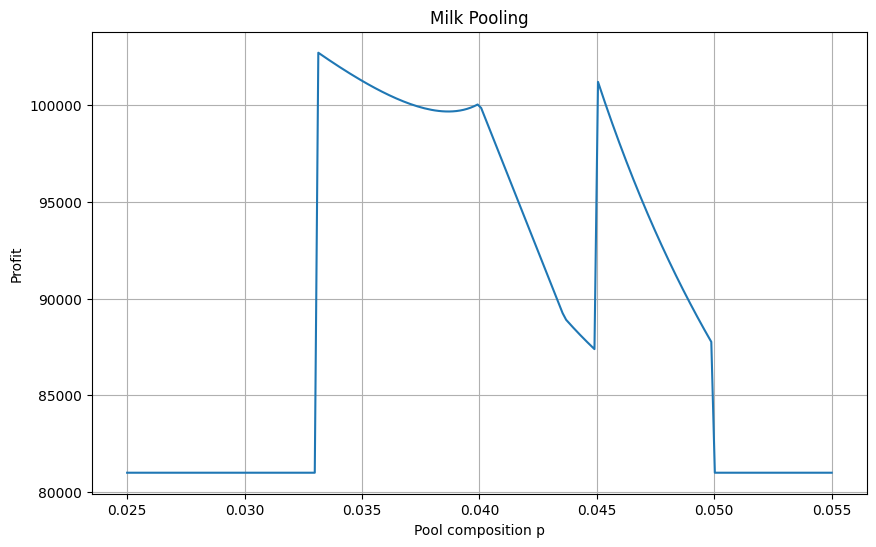

In [30]:
p_plot = np.linspace(0.025, 0.055, 200)
profit_plot = [milk_pooling(_).profit() for _ in p_plot]

fig, ax = plt.subplots(figsize=(10, 6))
ax.plot(p_plot, profit_plot)
ax.set_title("Milk Pooling")
ax.set_xlabel("Pool composition p")
ax.set_ylabel("Profit")
ax.grid(True)
plt.show()

The results show the maximum achievable profit with pooling is over than 102,000. What is needed is an optimization technique that can solve for the optimal pool composition and profit. This plot demonstrates how the non-convex bilinear constraints can result in multiple local maxima and a saddle points.

## Convex Approximation

Two of the constraints in the p-parameterized milk pooling model have bilinear terms $p y_c$ that are the product of decision variables $p$ and $y_c$ for $c\in C$. Designating the value of these terms as $w_c = p y_c$ the balance on milk fat in the inflow and outflow from the pool becomes a linear constraint

$$
\begin{align*}
\sum_{r\in R}\text{conc}_{r}\ x_{r}  & = \sum_{c\in C} w_{c}
\end{align*}
$$

and the blending constraint to meet the milk fat requirement for each customer becomes a set of linear constraints

$$
\begin{align*}
w_c + \sum_{(l,c)\ \in\ L \times C} \text{conc}_{l}\ z_{l,c}
& \geq \text{conc}_{c}\ (\sum_{l\in L} z_{l, c} + y_{c})
& \forall c \in C
\end{align*}
$$

What remain, of course, are the bilinear terms $w_c = p y_c$. The values of $y_c$ are bounded between 0 and the demand of customer $c$, and the value of $p$ is bounded between the minimum and maximum milk fat concentrations of the remote farms. The bilinear terms form a set of equality constraints and bounded decision variables.

$$
\begin{align*}
& w_c = p y_c & \forall c\in C \\
\\
0 \leq\ & y_c \leq \text{demand}_c\ & \forall c\in C \\
\min_{r\in R} \text{conc}_r \leq\ & p \leq \max_{r\in R} \text{conc}_r \\
\end{align*}
$$

One strategy to create to convert this bilinear problem into a linear problem is to replace the equality constraints $w_c = p y_c$ with a set of linear inequality constraints that keeps the difference $w_c - y p_c$ difference small. This process is a "relaxation" of the bilinear constraint with a goal of creating a problem with better computational characteristics. The process increases the space of admissible solutions which will result in an overly optimistic estimate of profit. 

Representing the bounds on $p$ and $y_c$ as 

$$
\begin{align*}
\underline{p} & \leq p \leq \bar{p} \\
\underline{y}_c & \leq y_c \leq \bar{y}_c & \forall c\in C 
\end{align*}
$$

the McCormick envelope on $w_c$ is given by a system of four inequalities. For each $c\in C$,

$$
\begin{align*}
w_c & \geq \underline{y}_c p + \underline{p} y_c - \underline{p}\underline{y}_c \\
w_c & \geq \bar{y}_c p + \bar{p} y_c - \bar{p}\bar{y}_c \\
w_c & \leq \bar{y}_c p + \underline{p} y_c - \bar{p}\underline{y}_c \\
w_c & \leq \underline{y}_c p + \bar{p} y_c - \underline{p}\bar{y}_c \\
\end{align*}
$$

The following cell implements these constraint in Pyomo. The features to note are:

* Use of a rule to specify bounds on the decision variables `m.y[c]`.
* Creating a new decision variable `m.p` with bounds.
* Creating a new set of decision variables `m.w[c]` to replace the bilinear terms.
* An indexed Pyomo `Block` to bound `m.w[c]` using McCormick envelopes.

The result of these operations is a linear model that will provide an upper bound on the profit. Hopefully the resulting solution and bound will be a close enough approximation to be useful.

In [31]:
import pyomo.environ as pyo

def milk_pooling_convex(q="fat"):
    
    m = pyo.ConcreteModel('Milk Pooling Model - Convex Approximation')

    # define sources 
    m.L = pyo.Set(initialize=local_suppliers.index)
    m.R = pyo.Set(initialize=remote_suppliers.index)

    # define customers
    m.C = pyo.Set(initialize=customers.index)

    # define flowrates
    m.x = pyo.Var(m.R, domain=pyo.NonNegativeReals)
    m.y = pyo.Var(m.C, bounds=lambda m, c: (0, customers.loc[c, "demand"]))
    m.z = pyo.Var(m.L * m.C, domain=pyo.NonNegativeReals)
    
    # composition of the pool
    m.p = pyo.Var(bounds=(remote_suppliers["fat"].min(), remote_suppliers["fat"].max()))
    
    # w[c] = p * y[c]
    m.w = pyo.Var(m.C, domain=pyo.NonNegativeReals)

    @m.Objective(sense=pyo.maximize)
    def profit(m):
        return + sum(m.z[l, c]*(customers.loc[c, "price"] - suppliers.loc[l, "cost"]) for l, c in m.L * m.C) \
               + sum(m.y[c]*customers.loc[c, "price"] for c in m.C) \
               - sum(m.x[r]*suppliers.loc[r, "cost"] for r in m.R)
    
    @m.Block(m.C)
    def mccormick(b, c):
        m = b.model()
        b.ll = pyo.Constraint(expr=m.w[c] >= m.y[c].lower * m.p + m.p.lower * m.y[c] - m.p.lower * m.y[c].lower)
        b.hh = pyo.Constraint(expr=m.w[c] >= m.y[c].upper * m.p + m.p.upper * m.y[c] - m.p.upper * m.y[c].upper)
        b.lh = pyo.Constraint(expr=m.w[c] <= m.y[c].upper * m.p + m.p.lower * m.y[c] - m.p.lower * m.y[c].upper)
        b.hl = pyo.Constraint(expr=m.w[c] <= m.y[c].lower * m.p + m.p.upper * m.y[c] - m.p.upper * m.y[c].lower)  

    @m.Constraint(m.C)
    def customer_demand(m, c):
        return sum(m.z[l, c] for l in m.L) + m.y[c] <= customers.loc[c, "demand"]
    
    @m.Constraint()
    def pool_balance(m,):
        return sum(m.x[r] for r in m.R) == sum(m.y[c] for c in m.C)
    
    @m.Constraint()
    def pool_quality(m):
        return sum(suppliers.loc[r, q] * m.x[r] for r in m.R) == sum(m.w[c] for c in m.C)
    
    @m.Constraint(m.C)
    def customer_quality(m, c):
        return m.w[c] + sum(suppliers.loc[l, q] * m.z[l, c] for l in m.L) \
                 >= customers.loc[c, q] * (sum(m.z[l, c] for l in m.L) + m.y[c])

    pyo.SolverFactory('cbc').solve(m)
    
    return m

m_convex = milk_pooling_convex()
report_solution(m_convex)

Milk Pooling Model - Convex Approximation

Pool composition = 0.04
Profit = 111411.76

Supplier Report



,fat,cost,location,Customer 1,Customer 2,Customer 3,Pool,Amount,Expense
Farm A,0.045,45.0,local,2500.0,0.0000,0.0,0.0000,2500.0000,112500.0000
Farm B,0.030,42.0,local,0.0,1029.4118,0.0,0.0000,1029.4118,43235.2956
Farm C,0.033,37.0,remote,0.0,0.0000,0.0,4852.9412,4852.9412,179558.8244
Farm D,0.050,45.0,remote,0.0,0.0000,0.0,4117.6471,4117.6471,185294.1195



Customer Report



,fat,price,demand,Farm A,Farm B,Pool,Amount,fat delivered,Income
Customer 1,0.045,52.0,6000.0,2500.0,0.0000,3500.0000,6000.0,0.0421,312000.0
Customer 2,0.030,48.0,2500.0,0.0,1029.4118,1470.5882,2500.0,0.0359,120000.0
Customer 3,0.040,50.0,4000.0,0.0,0.0000,4000.0000,4000.0,0.0400,200000.0


The convex approximation of the milk pooling model estimates an upper bound on profit of 111,412 for a pool composition $p = 0.040$. The plot below compares this solution to what was found by in an exhaustive search over values of $p$.

Text(0.035, 108000, 'convex approximation')

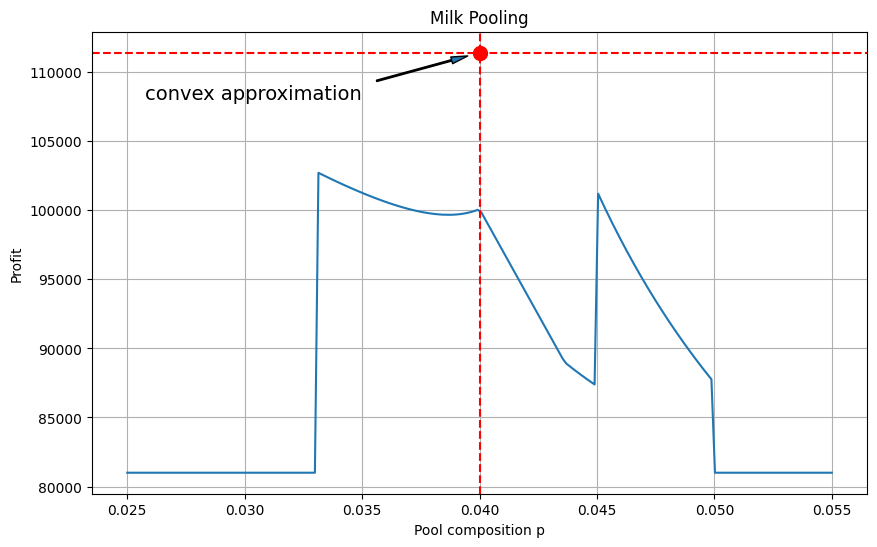

In [32]:
fig, ax = plt.subplots(figsize=(10, 6))
ax.plot(p_plot, profit_plot)
ax.set_title("Milk Pooling")
ax.set_xlabel("Pool composition p")
ax.set_ylabel("Profit")
ax.grid(True)

ax.plot(m_convex.p(), m_convex.profit(), 'ro', ms=10)
ax.axhline(m_convex.profit(), color='r', linestyle='--')
ax.axvline(m.p(), color='r', linestyle='--')
ax.annotate("convex approximation", xy=(m_convex.p(), m_convex.profit()),
            xytext=(0.035, 108000), ha="right", fontsize=14,
            arrowprops=dict(shrink=0.1, width=1, headwidth=5))

The convex approximation is clearly misses the market in the estimate of profit and pool composition $p$. Without the benefit of the full scan of profit as a function of $p$, the only check on the profit estimate would be to compute the solution to model for the reported value of $p$. This is done below.

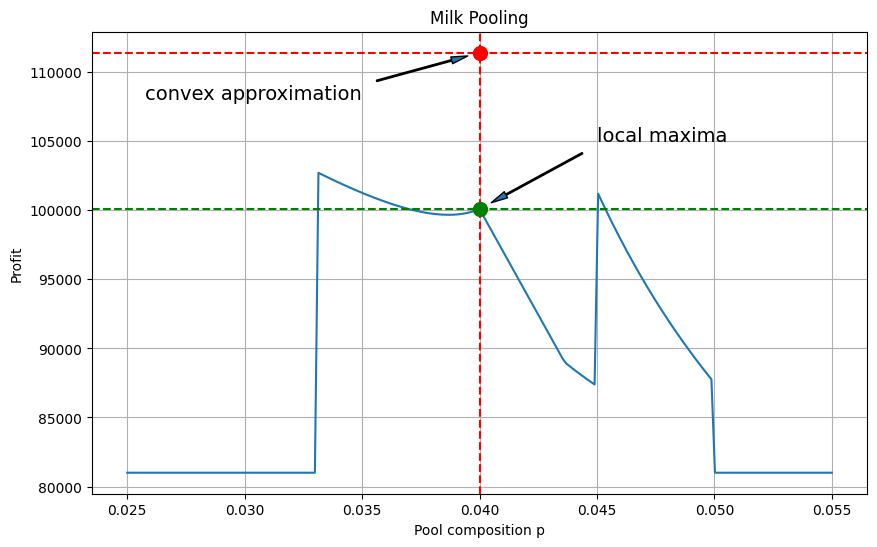

In [33]:
m_est = milk_pooling(m_convex.p())

fig, ax = plt.subplots(figsize=(10, 6))
ax.plot(p_plot, profit_plot)
ax.set_title("Milk Pooling")
ax.set_xlabel("Pool composition p")
ax.set_ylabel("Profit")
ax.grid(True)

ax.plot(m_convex.p(), m_convex.profit(), 'ro', ms=10)
ax.axhline(m_convex.profit(), color='r', linestyle='--')
ax.axvline(m.p(), color='r', linestyle='--')
ax.annotate("convex approximation", xy=(m_convex.p(), m_convex.profit()),
            xytext=(0.035, 108000), ha="right", fontsize=14,
            arrowprops=dict(shrink=0.1, width=1, headwidth=5))

ax.plot(m_est.p(), m_est.profit(), 'go', ms=10)
ax.axhline(m_est.profit(), color='g', linestyle='--')
ax.annotate("local maxima", xy=(m_convex.p(), m_est.profit()),
            xytext=(0.045, 105000), ha="left", fontsize=14,
            arrowprops=dict(shrink=0.1, width=1, headwidth=5))
plt.show()

In [34]:
report_solution(m_est)

Milk Pooling Model

Pool composition = 0.04
Profit = 100088.24

Supplier Report



,fat,cost,location,Customer 1,Customer 2,Customer 3,Pool,Amount,Expense
Farm A,0.045,45.0,local,6000.0,0.0,0.0,0.0000,6000.0000,270000.0000
Farm B,0.030,42.0,local,0.0,0.0,0.0,0.0000,0.0000,0.0000
Farm C,0.033,37.0,remote,0.0,0.0,0.0,3823.5294,3823.5294,141470.5878
Farm D,0.050,45.0,remote,0.0,0.0,0.0,2676.4706,2676.4706,120441.1770



Customer Report



,fat,price,demand,Farm A,Farm B,Pool,Amount,fat delivered,Income
Customer 1,0.045,52.0,6000.0,6000.0,0.0,0.0,6000.0,0.045,312000.0
Customer 2,0.030,48.0,2500.0,0.0,0.0,2500.0,2500.0,0.040,120000.0
Customer 3,0.040,50.0,4000.0,0.0,0.0,4000.0,4000.0,0.040,200000.0


With regard to the practical impact, the results of using this particular convex approximation are mixed. The approximation did successfully produce a value for the pool composition $p$ which would produce a profit of over 100,000. However, the reported value for $p$ was actually the smallest of the three local maxima for this problem. This large discrepancy may have large consequences regarding the choice of suppliers.

## Nonlinear optimization

The final version of this milk pooling model returns to the bilinear formulation with pool composition $p$ as a decision variable. The following Pyomo implementation needs to specify a solver capable of solving the resulting problem. This has been tested with nonlinear solvers [`ipopt`](https://github.com/coin-or/Ipopt) and [`couenne`](https://github.com/coin-or/Couenne). [Pre-compiled binaries for these solvers can be downloaded from AMPL](https://ampl.com/products/solvers/open-source/). 

In [35]:
import pyomo.environ as pyo

def milk_pooling_bilinear(q="fat"):
    
    m = pyo.ConcreteModel('Milk Pooling Model - Bilinear')

    # define sources 
    m.L = pyo.Set(initialize=local_suppliers.index)
    m.R = pyo.Set(initialize=remote_suppliers.index)

    # define customers
    m.C = pyo.Set(initialize=customers.index)

    # define flowrates
    m.x = pyo.Var(m.R, domain=pyo.NonNegativeReals)
    m.y = pyo.Var(m.C, bounds=lambda m, c: (0, customers.loc[c, "demand"]))
    m.z = pyo.Var(m.L * m.C, domain=pyo.NonNegativeReals)
    
    m.p = pyo.Var(bounds=(remote_suppliers["fat"].min(), remote_suppliers["fat"].max()))

    @m.Objective(sense=pyo.maximize)
    def profit(m):
        return + sum(m.z[l, c]*(customers.loc[c, "price"] - suppliers.loc[l, "cost"]) for l, c in m.L * m.C) \
               + sum(m.y[c]*customers.loc[c, "price"] for c in m.C) \
               - sum(m.x[r]*suppliers.loc[r, "cost"] for r in m.R)

    @m.Constraint(m.C)
    def customer_demand(m, c):
        return sum(m.z[l, c] for l in m.L) + m.y[c] <= customers.loc[c, "demand"]
    
    @m.Constraint()
    def pool_balance(m,):
        return sum(m.x[r] for r in m.R) == sum(m.y[c] for c in m.C)
    
    @m.Constraint()
    def pool_quality(m):
        return sum(suppliers.loc[r, q] * m.x[r] for r in m.R) == m.p * sum(m.x[r] for r in m.R)
    
    @m.Constraint(m.C)
    def customer_quality(m, c):
        return m.p * m.y[c] + sum(suppliers.loc[l, q] * m.z[l, c] for l in m.L) \
                 >= customers.loc[c, q] * (sum(m.z[l, c] for l in m.L) + m.y[c])

    pyo.SolverFactory('couenne').solve(m)
    
    return m


In [36]:
m_global = milk_pooling_bilinear()

fig, ax = plt.subplots(figsize=(10, 6))
ax.plot(p_plot, profit_plot)
ax.set_title("Milk Pooling")
ax.set_xlabel("Pool composition p")
ax.set_ylabel("Profit")
ax.grid(True)

ax.plot(m_convex.p(), m_convex.profit(), 'ro', ms=10)
ax.axhline(m_convex.profit(), color='r', linestyle='--')
ax.axvline(m.p(), color='r', linestyle='--')
ax.annotate("convex approximation", xy=(m_convex.p(), m_convex.profit()),
            xytext=(0.035, 108000), ha="right", fontsize=14,
            arrowprops=dict(shrink=0.1, width=1, headwidth=5))

ax.plot(m_est.p(), m_est.profit(), 'go', ms=10)
ax.axhline(m_est.profit(), color='g', linestyle='--')
ax.annotate("local maxima", xy=(m_convex.p(), m_est.profit()),
            xytext=(0.045, 105000), ha="left", fontsize=14,
            arrowprops=dict(shrink=0.1, width=1, headwidth=5))

ax.plot(m_global.p(), m_global.profit(), 'bo', ms=10)
ax.axhline(m_global.profit(), color='b', linestyle='--')
ax.annotate("global maxima", xy=(m_global.p(), m_global.profit()),
            xytext=(0.025, 95000), ha="left", fontsize=14,
            arrowprops=dict(shrink=0.1, width=1, headwidth=5))

report_solution(m_global)

    for solver asl. File with name=couenne either does not exist or it is not
    executable. To skip this validation, call set_executable with
    validate=False.
Traceback (most recent call last):
  File "/Users/ale/.pyenv/versions/3.10.6/lib/python3.10/site-packages/pyomo/opt/base/solvers.py", line 166, in __call__
    opt = self._cls[_implicit_solvers[mode]](**kwds)
  File "/Users/ale/.pyenv/versions/3.10.6/lib/python3.10/site-packages/pyomo/solvers/plugins/solvers/ASL.py", line 44, in __init__
    SystemCallSolver.__init__(self, **kwds)
  File "/Users/ale/.pyenv/versions/3.10.6/lib/python3.10/site-packages/pyomo/opt/solver/shellcmd.py", line 56, in __init__
    self.set_executable(name=executable, validate=validate)
  File "/Users/ale/.pyenv/versions/3.10.6/lib/python3.10/site-packages/pyomo/opt/solver/shellcmd.py", line 104, in set_executable
    raise ValueError(
ValueError: Failed to set executable for solver asl. File with name=couenne either does not exist or it is not execut

RuntimeError: Attempting to use an unavailable solver.

The SolverFactory was unable to create the solver "couenne"
and returned an UnknownSolver object.  This error is raised at the point
where the UnknownSolver object was used as if it were valid (by calling
method "solve").

The original solver was created with the following parameters:
	executable: couenne
	type: couenne
	_args: ()
	options: {}

## Concluding Remarks

The solution for the bilinear pooling model reveals several features of the problem. 

* For the given parameters, pooling raw materials for shipment from remote suppliers yields the most profitable solution, but that solution is only possible because there are local suppliers to augment the pool blend to meet individual customer requirements. 

* Customer 2 receives a blend that is 3.3% exceeding the requirement of 3%. This results in some "give away" of product quality in return for the economic benefits of pooling.

## Suggested Exercises

This simple model demonstrates practical issues that arise in modeling the non-convex problems. Take time explore the behavior of the model to parameter changes and the nature of the solution. 

1. Examine the model data and explain why the enhanced profits are observed only for a particular range of values in $p$.

2. Think carefully about the non-convex behavior observed in the plot of profit versus parameter $p$.  Why are the local maxima located where they are, and how are they related to problem data? Test your hypothesis by changing the problem data.  What happens when the product specification for Customer A is set equal to 0.045? What happens when it is set to 0.04?

3. Revise the Pyomo model using 'cbc', 'gurobi_direct', 'ipopt', and 'bonmin' to find a solution. Did you find a solver that could solve this nonlinear problem?

4. The above analysis assumed unlimited transport. If the truck turns out to have a limit of 4,000 units of milk, write the mathematical constraint necessary to introduce that limit into the model. Add that constraint to the Pyomo model and discuss the impact on profit.